In [1]:
# importing packages and libraries
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path

# https://pypi.org/project/Pillow/
# https://pypi.org/project/Pillow/
from PIL import Image

# https://pypi.org/project/pytesseract/
# pip install pytesseract
import pytesseract

# https://pypi.org/project/easyocr/
# pip install easyocr
import easyocr

# https://pypi.org/project/python-doctr/
# pip install python-doctr
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

# https://pypi.org/project/python-Levenshtein/
# pip install python-Levenshtein
from Levenshtein import distance, ratio

# https://pypi.org/project/plotly/
# pip install plotly
import plotly.figure_factory as ff

# https://pypi.org/project/opencv-python/
# pip install opencv-python==4.5.5.64
import cv2

import warnings

/Users/rfunke/miniforge3/envs/deeplearning/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/rfunke/miniforge3/envs/deeplearning/lib/python3.9/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


# Comparing different OCR engine on the same set of images

The goal of this comparison is to find out which OCR engine performs best in regards to the expected image quality attributes.

In order to make the resulting outputs for each engine comparable we are applying the Levenshtein Distance and Levenshtein Ratio. A higher Levenshtein Distance represents a higher deviation from the ground truth. The Levenshtein Ratio normalizes this over the total length of a given string. This allows meassuring the difference between two strings. In this application the first string will be the ground truth and the second string the respective output from an OCR engine, so we can calculate the accuracy for a given engine on a given picture.

## Approach

The base collection of images is downloaded from openfoodfacts.org and made up of 85 images. When required the images were cropped, and modified to isolate the ingredient list as well as possible. The images for the test are stored in the directory 'Ingredients'.

For each image a text file containing the ground truth, with a string of the ingredients shown in each image was created. These were obtained by first running OCR with Abbyy Fine Reader, then corrected by hand. The files are stored in the directory 'Ingredient_lists'.

The execution of each engine is wrapped in a function that contains the loading of a picture, running OCR on that picture and returning the output as a string.

A different function will load the corresponding .txt-file for the picutre containing the actual ingredients.

For each engine, we then iterate through each file in the directory 'Ingredients', to get the OCR result and store it with the actual ingredients in a dictionary. Based on the output of the OCR engine and its ground truth we calculate the Levenshtein distance and ratio for each picture. These will respectively stored in another dict, which will then be turned into a dataframe.

This will give us the Levenshtein distance and Levenshtein Ratio for each picture analyzed by each engine, which allows for easy comparison.

## Configuring OCR engine for experiment

In [2]:
def OCR_pytesseract(img_file_name):
    # reading file
    image = Image.open(img_file_name)

    # Feed file to engine
    ocr_out = pytesseract.image_to_string(image)
    
    return ocr_out

In [3]:
def OCR_easyOCR(img_file_name):
    # reading file
    image = Image.open(img_file_name)

    # inputting and analyzing file
    result = easyocr.Reader(['de'], gpu=False, verbose=False).readtext(image)

    # string to store results per line
    ocr_out = ''
    # iterating through lines, join with a line break
    for line in result:
        ocr_out = '\n'.join([ocr_out, line[1]])

    # return result string
    return ocr_out

In [4]:
def OCR_docTR(img_file_name):
    # reading file
    doc = DocumentFile.from_images(img_file_name)

    # configure model
    model = ocr_predictor('db_resnet50', 'crnn_vgg16_bn', pretrained=True)

    # storing output
    json_output = model(doc).export()

    # iterating through JSON output structure
    ingredients = []
    for page in json_output['pages']:
        for block in page['blocks']:
            for line in block['lines']:
                words_in_line = []

                for word in line['words']:
                    words_in_line.append(word['value'])
                ingredients.append(words_in_line)

    ingredients2 = []
    for element in ingredients:
        ingredients2.append(' '.join(element))

    # joining each line with a line break to recreate the original representation
    ocr_out = '\n'.join(ingredients2)

    # return result string
    return ocr_out

In [5]:
def do_OCR(engine, img_file_name):
    """Takes one of three engines and a file path, then executes the respective OCR function.

    Args:
        engine: is currently using Pytesseract, easyOCR and docTR
        img_file_name: path to image file to be analyzed

    Returns:
        string: resulting OCR engine output
    """
    if engine == 'Pytesseract':
        return OCR_pytesseract(img_file_name)

    if engine == 'easyOCR':
        return OCR_easyOCR(img_file_name)

    if engine == 'docTR':
        return OCR_docTR(img_file_name)

## Loading ground truths for experiment

In [6]:
def read_ingredients_txt(img_file_name:str):
    """Takes vthe file path and returns the contents
    of the ingredients .txt file for a given image path.

    Args:
        img_file_name (str): Image path of ingredients .txt file to be returned

    Returns:
        True Ingredients (str): Contents of the ingredients .txt file
    """

    read_ingredients_txt.txt_file = img_file_name.replace('jpg', 'txt')

    with open(read_ingredients_txt.txt_file, 'r') as f:
        true_text = f.read()

    return true_text

## Configuring experiment

In [7]:
def make_comparison(directory_imgfiles: str, directory_groundtruths: str):
    """Iterates through the list 'engines', executes the functions 'do_OCR' and 'read_ingredients_txt'.
    Then calculates Levenshtein distance and ratio for every image then stores results in a dataframe.

    Args:
        directory_imgfiles (str): Directory of folder holding images
        directory_groundtruths (str): Directory of folder holding ground truth txt files.

    Returns:
        df_res: Combined results of all engines on all images
        df_viz: Copy of df_res for plotting
        fig: Plot of Distribution of Levenshtein Ratios per Engine
    """
    # dict to store file paths and OCR results
    ocr_results = {}

    # dict to store file paths and ground truths
    ground_truths = {}

    # list with engines
    engines = ['Pytesseract', 'easyOCR', 'docTR']

    # list for dataframes
    results = []

    for engine in engines:
        # loading all .jpg-files in directory Ingredients
        print(f'Running: {engine}')
        for path in Path(directory_imgfiles).glob('*.jpg'):
            # because path is object not string
            filename_image = str(path)
            # creating filename_txt by replacing .jpg with .txt
            filename_txt = str(directory_groundtruths / Path(path.with_suffix('.txt').name))

            # calling do_OCR and storing results
            ocr_results[filename_image] = do_OCR(engine, filename_image)

            # calling read_ingredients_txt and storing results
            ground_truths[filename_image] = read_ingredients_txt(filename_txt)

        # dict to store file paths and levenshtein distances
        levenshtein_distances = {}
        # dict to store file paths and levenshtein ratios
        levenshtein_ratios = {}
        # iterating though each image its OCR result
        for filename_image, ocr_result in ocr_results.items():
            # calculating and storing distance between ground truth and OCR result
            levenshtein_distances[filename_image] = distance(ground_truths[filename_image], ocr_result)
            # calculating and storing ratio between ground truth and OCR result
            levenshtein_ratios[filename_image] = ratio(ground_truths[filename_image], ocr_result)

        # converting levenshtein results into single dataframe
        results.append(pd.concat([
            pd.DataFrame.from_dict(levenshtein_distances, columns=[f'distance_{engine}'], orient='index'),
            pd.DataFrame.from_dict(levenshtein_ratios, columns=[f'ratio_{engine}'], orient='index')], axis=1))

    # combinging results into single dataframe
    df_res = pd.concat(results, axis=1)
    df_res = df_res.sort_index()

    return df_res

## Executing Experiment

In [8]:
# to prevent depreciation warnings when running docTR
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=UserWarning)

    # executing experiment and storing results in df_res
    df_res = make_comparison('Ingredients', 'Ingredient_lists')

# saving results as pickle
df_res.to_pickle('./df_res.pkl')

Running: Pytesseract
Running: easyOCR
Running: docTR


## Visualzing Levenshtein Ratios

In [9]:
# copy of results dataframe for visualization
df_hist = pd.read_pickle('./df_res.pkl')

# add histogram data and group data together
hist_data = [df_hist['ratio_docTR'].values,
             df_hist['ratio_easyOCR'].values,
             df_hist['ratio_Pytesseract'].values]
             
group_labels = ['docTR', 'easyOCR', 'Pytesseract']

# create distplot 
fig = ff.create_distplot(hist_data, group_labels, bin_size=.1)
fig.update_layout(
    title='Distribution of Levenshtein Ratios per Engine',
    xaxis_title='Ratio (higher is better)',
    yaxis_title='Number of occurances')

fig.show()

When plotting the distribution of Levenshtein Ratios per engine. We find easyOCR has the highest share of results with ratios large than 0.9 while the lowest result has a ratio of 0.41, which shows that easyOCR yielded the best results on this particular set of images.

Pytesseract performed fairly well with 40% of the results being above 0.9, especially considering the speed of the module compared to easyOCR and docTR.



## Preparing Results for Visualization

In [10]:
# loading df_res pickle into df_viz
df_viz = pd.read_pickle('./df_res.pkl')

# selecting columns with ratios
df_viz = df_viz[['ratio_Pytesseract', 'ratio_easyOCR', 'ratio_docTR']]

# turning values from decimal to percentage
df_viz = df_viz*100

# rounding ratio values to third decimal
df_viz = df_viz.round(1)

In [11]:
# assigning results
pytesseract_res = df_viz.sort_values('ratio_Pytesseract').iloc[:, [0]]
easyocr_res = df_viz.sort_values('ratio_easyOCR').iloc[:, [1]]
doctr_res = df_viz.sort_values('ratio_docTR').iloc[:, [2]]

## Comparison of Representative Pytesseract Examples

In [12]:
def make_img_grid(ocr_engine_results, engine_name):
    # create figure, setting values to rows and column variables
    fig = plt.figure(figsize=(16, 10))
    rows, columns = 3, 3 
    
    # selecting top, middle and bottom three indices
    indices = [84, 83, 82, 43, 42, 41, 2, 1, 0]
    
    # creating list of images
    images = [cv2.imread(ocr_engine_results.index[i])[...,::-1]
              for i in indices]
              
    # creating list of ratios
    ratios = [ocr_engine_results[f'ratio_{engine_name}'][i]
              for i in indices]

    for i, (image, ratio) in enumerate(zip(images, ratios)):
        fig.add_subplot(rows, columns, i+1)
        # showing image
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'ratio = {ratio}')
    
    fig.patch.set_facecolor('1')
    fig.suptitle(
    f'{engine_name}, Levenshtein Ratios in % \n Top, Middle & Bottom 3 Examples\n Best to worst: Top to Bottom and Left to Right\n',
    fontsize=16);
    
    return fig.show();

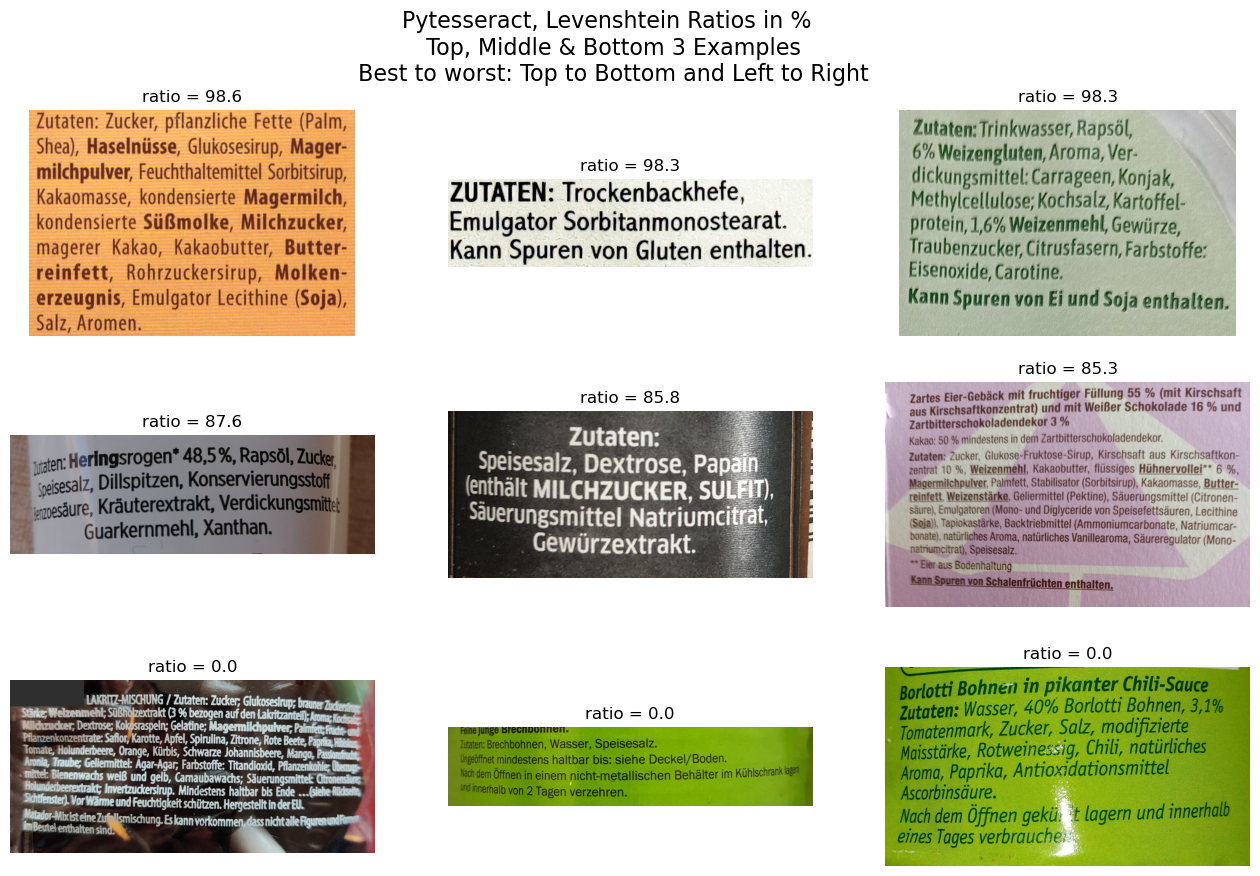

In [13]:
# to prevent user warnings by matplotlib
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=UserWarning)

    # plotting image grid
    make_img_grid(pytesseract_res, 'Pytesseract')

### Analysis of the Performance of Pytesseract

In [14]:
# calculating pytesseract percentage of zero-value results
(pytesseract_res.ratio_Pytesseract == 0.000).sum()/len(df_viz)*100

10.588235294117647

In [15]:
# displaying performance results
pytesseract_res.describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
ratio_Pytesseract,85.0,70.6,32.4,0.0,59.0,85.8,94.2,98.6


Pytesseract performs reasonably well on pictures with warped and tilted text or pictures with low contrast, like the first image in the second row. 

Suprisingly it was not able to produce any result for the second picture in the third row. 

For 10% of the pictures it was not able to produce any result.

The average Levenshtein Ratio achieved on this image set is 70.6 % with a standard deviation of 32.4 %.

_______

## Comparison of Representative easyOCR Examples

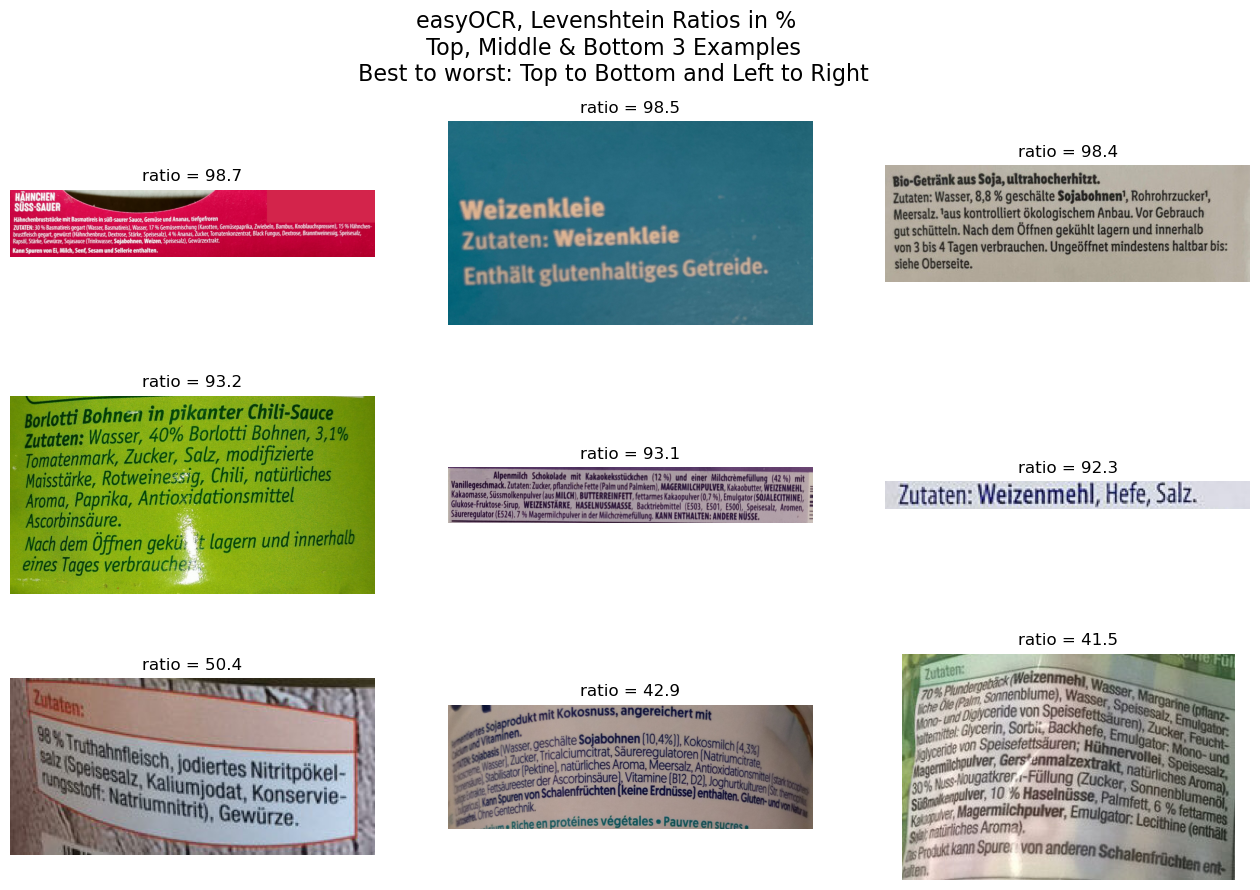

In [16]:
# to prevent user warnings by matplotlib
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=UserWarning)

    # plotting image grid
    make_img_grid(easyocr_res, 'easyOCR')

### Analysis of the Performance of easyOCR

In [17]:
# calculating easyOCR percentage of zero-value results
(easyocr_res.ratio_easyOCR == 0.000).sum()/len(df_viz)*100

0.0

In [18]:
# displaying performance results
easyocr_res.describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
ratio_easyOCR,85.0,87.2,13.2,41.5,83.7,93.1,96.2,98.7


EasyOCR performs very well on pictures with warped and tilted text or pictures with low contrast, like those shown in the third row. 

It was able to produce a result for every image and achieved a Levenshtein Ratio of 41 % at minimum.

The average Levenshtein Ratio is 87 % with a standard deviation of 13 %.
_______

## Comparison of Representative docTR Examples

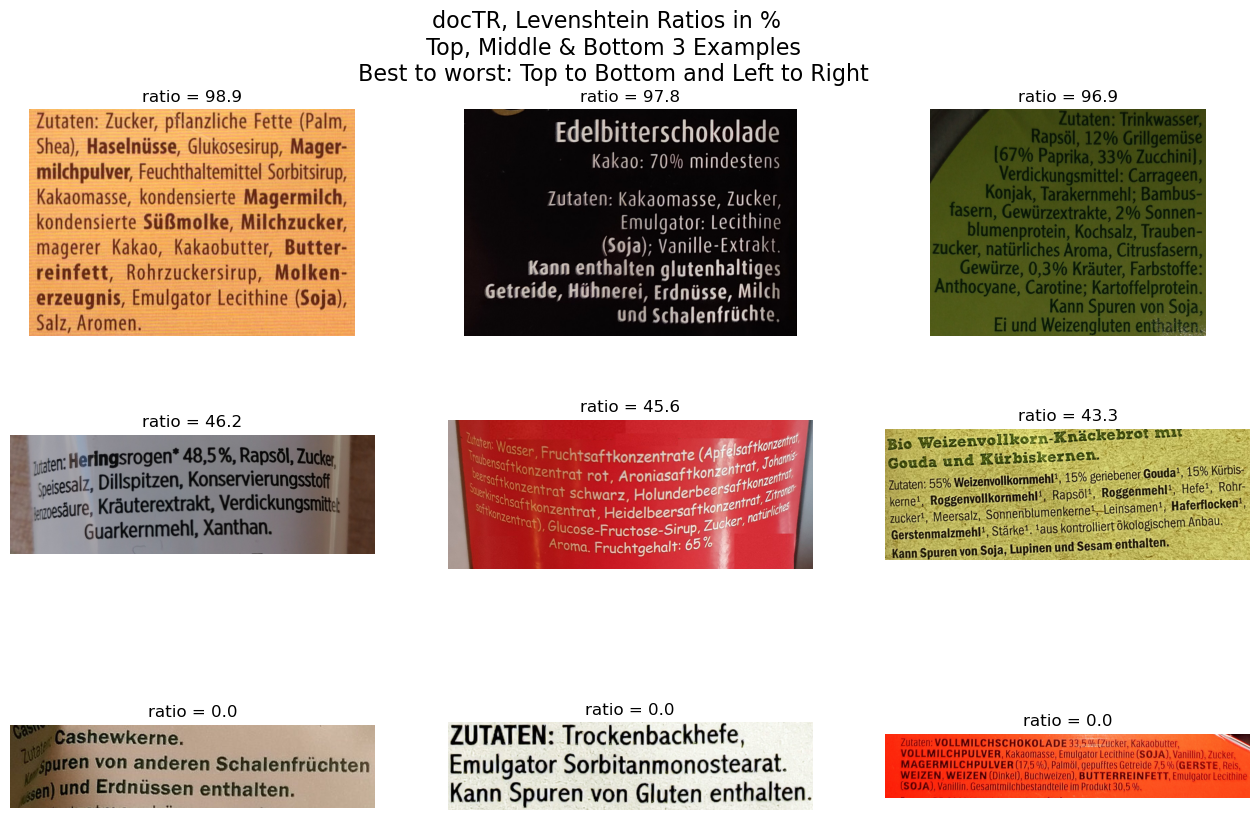

In [19]:
# to prevent user warnings by matplotlib
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=UserWarning)

    # plotting image grid
    make_img_grid(doctr_res, 'docTR')

### docTR Evaluation

In [20]:
# calculating docTR percentage of zero-value results
(doctr_res.ratio_docTR == 0.000).sum()/len(df_viz)*100

34.11764705882353

In [21]:
# displaying performance results
doctr_res.describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
ratio_docTR,85.0,42.2,39.0,0.0,0.0,45.6,82.9,98.9


In this comparison docTR showed the worst performance, as it was not able to produce any result for 34 % of the image set. 

It appears to be struggling quickly as the image quality decreases. A notebale case of this would be the second image in the third row, which doesn't suffer too much from bad image quality yet docTR was not able to extract any text from it.
_______

# Conclusion

In [22]:
# displayin mean and standard deviation of Levenshtein Ratio per engine, sorted by mean descending
df_viz.describe().T.round(1)[['mean', 'std']].sort_values('mean', ascending=False)

,mean,std
ratio_easyOCR,87.2,13.2
ratio_Pytesseract,70.6,32.4
ratio_docTR,42.2,39.0


docTR produced an average Levenshtein Ratio of 42 % with a standard deviation of 39 %. This is both the lowest average score and the highest standard deviation. This puts docTR in the third place in this comparison.

The average Levenshtein Ratio achieved by Pytesseract on this image set is 70.6 % with a standard deviation of 32.4 %, which this puts Pytesseract in second place in this comparison.

In this comparison easyOCR scored the highest mean ratio of 87 % and lowest standard deviation of 13 %, making it the clear winner in this comparison.

The reasons for the comparatively better performance seems to stem from the ability to extract at least some information even from very difficult images for which the other engines produce no results at all.

Based on this outcome we suggest to use easyOCR in further development of OCR solutions for Sustomer.

_______
______